In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jacfwd

In [2]:
from src.two_step_richtmyer_util import Dimension

In [3]:
dim = Dimension.twoD

In [4]:
def pbc(grid: np.ndarray, dim: Dimension):
    # x dimension
    grid = grid.at[0, ...].set(grid[-2, ...])
    grid = grid.at[-1, ...].set(grid[1, ...])
    # y dimension
    grid = grid.at[:, 0, ...].set(grid[:, -2, ...])
    grid = grid.at[:, -1, ...].set(grid[:, 1, ...])
    return grid


In [5]:
def pde(v):
    gamma = 5/3
    def pres(v):
        dens = v[..., 0]
        Etot = v[..., -1]
        Ekin = 0.5 * jnp.sum(v[..., 1:dim.value + 1] ** 2, axis=-1) / dens
        eint = Etot - Ekin
        return eint * (gamma - 1.)
    p = pres(v)
    dens = v[..., 0]
    vels = v[..., 1:dim.value + 1] / dens[..., jnp.newaxis]
    Etot = v[..., -1]
    result = jnp.empty((*v.shape, dim.value))

    result = result.at[..., 0, :].set(v[..., 1:dim.value + 1])
    result = result.at[..., 1:dim.value + 1, :].set(jnp.einsum("...i,...j->...ij", v[..., 1:dim.value + 1], vels) \
                                         + jnp.einsum("...i,jk->...ijk", p, jnp.identity(dim.value)))
    result = result.at[..., -1, :].set(jnp.einsum("...,...i->...i", Etot + p, vels))

    return tuple(result[..., i] for i in range(dim.value))

In [6]:
def waves(k, w0, amp, alpha=None):
    gamma = 5/3
    def primitive_to_conserved(w):
        dens = w[..., 0]
        v = w[..., 1:dim.value + 1]
        p = w[..., -1]
        conserved_w = np.empty(w.shape)
        conserved_w[..., 0] = dens
        for i in range(dim.value):
            conserved_w[..., i + 1] = dens * v[..., i]
        conserved_w[..., -1] = p / (gamma - 1) + 0.5 * dens * np.sum(v ** 2, axis=-1)
        return conserved_w
    dens = w0[0]
    v = w0[1]
    p = w0[2]
    # conserved_w = np.array([dens, dens * v, p / (self.gamma - 1) + dens / 2 * v ** 2])
    a = np.sqrt(gamma * p / dens)
    eigen_vectors = np.array([[2, dens / a, -dens / a],
                              [0, 1, 1],
                              [0, dens * a, -dens * a]]) / 2
    eigen_vals = np.array([v, v + a, v - a])

    cos_alpha = np.cos(alpha)
    Rinv = np.array([[cos_alpha, np.sin(alpha)],
                     [-np.sin(alpha), cos_alpha]])
    R = np.array([[cos_alpha, -np.sin(alpha)],
                  [np.sin(alpha), cos_alpha]])

    def wave(x, t=0):
        """x needs to be normalized to [0, 1]"""
        rotx = x @ R
        # NOTE: whole input * 2 * cos_alpha in case of pi/4
        w = w0 + amp * np.einsum("i,...j->...ji", eigen_vectors[:, k],
                                 np.sin(2 * np.pi * (rotx[..., 0] - eigen_vals[k] * t)))
        # first rotate then transform
        vxy = np.zeros((*w.shape[:-1], dim.value))
        vxy[..., 0] = w[..., 1]
        rotv = vxy @ Rinv

        w2d = np.empty((*w.shape[:-1], 4))
        w2d[..., 0] = w[..., 0]
        w2d[..., 1:dim.value + 1] = rotv
        w2d[..., 3] = w[..., 2]
        return primitive_to_conserved(w2d)

    return wave

In [41]:
N = 10

coords = [np.linspace(0, 1, N) for _ in range(2)]
avg_coords = [0.5 * (coord[1:] + coord[:-1]) for coord in coords]
XYZ = np.stack(np.meshgrid(*avg_coords, indexing='ij'), axis=-1)
grid_old = jnp.empty((N+1, N+1, 4))
grid_old = grid_old.at[1:-1, 1:-1].set(waves(0, np.array([1, 1, 1]), amp=1e-3, alpha=0)(XYZ))
grid_old = pbc(grid_old, dim=dim)
print(grid_old[1:-1, 1:-1].ravel())

[1.000342  1.000342  0.        2.000171  1.000342  1.000342  0.
 2.000171  1.000342  1.000342  0.        2.000171  1.000342  1.000342
 0.        2.000171  1.000342  1.000342  0.        2.000171  1.000342
 1.000342  0.        2.000171  1.000342  1.000342  0.        2.000171
 1.000342  1.000342  0.        2.000171  1.000342  1.000342  0.
 2.000171  1.000866  1.000866  0.        2.000433  1.000866  1.000866
 0.        2.000433  1.000866  1.000866  0.        2.000433  1.000866
 1.000866  0.        2.000433  1.000866  1.000866  0.        2.000433
 1.000866  1.000866  0.        2.000433  1.000866  1.000866  0.
 2.000433  1.000866  1.000866  0.        2.000433  1.000866  1.000866
 0.        2.000433  1.0009848 1.0009848 0.        2.0004923 1.0009848
 1.0009848 0.        2.0004923 1.0009848 1.0009848 0.        2.0004923
 1.0009848 1.0009848 0.        2.0004923 1.0009848 1.0009848 0.
 2.0004923 1.0009848 1.0009848 0.        2.0004923 1.0009848 1.0009848
 0.        2.0004923 1.0009848 1.0009848 

In [8]:
def del_x(grid_vals: np.ndarray) -> np.ndarray:
    return (grid_vals[2:, ...] - grid_vals[:-2, ...]) / 2

def del_y(grid_vals: np.ndarray) -> np.ndarray:
    return (grid_vals[:, 2:, ...] - grid_vals[:, :-2, ...]) / 2

def avg_x(grid_vals: np.ndarray) -> np.ndarray:
    return grid_vals[1:-1, ...]
    # return (grid_vals[2:, ...] + grid_vals[1:-1, ...] + grid_vals[:-2, ...]) / 4

def avg_y(grid_vals: np.ndarray) -> np.ndarray:
    return grid_vals[:, 1:-1, ...]
    # return (grid_vals[:, 2:, ...] + grid_vals[:, 1:-1, ...] + grid_vals[:, :-2, ...]) / 4

In [34]:
def F(v):
    c = 0.7271309652455544 * np.array([3, 3])
    grid = jnp.empty((N+1, N+1, 4))
    grid = grid.at[1:-1, 1:-1].set(jnp.reshape(v, (N-1, N-1, 4)))
    grid = pbc(grid, dim=Dimension.twoD)
    avg_t = 0.5 * (grid + grid_old)
    fluxes = pde(avg_t)
    return jnp.ravel(grid[1:-1, 1:-1] - grid_old[1:-1, 1:-1] + c[0] * del_x(avg_y(fluxes[0]))
            + c[1] * del_y(avg_x(fluxes[1])))

In [43]:
J = jacfwd(F)(grid_old[1:-1, 1:-1])


In [36]:
np.array(J).shape

(1444, 19, 19, 4)

In [26]:
np.savetxt('jac.csv', J.reshape((N-1)**2*4, (N-1)**2*4), delimiter=',',fmt='%3.0f')

In [69]:
import jax

In [31]:
jnp.min(J)

Array(-1.6374087, dtype=float32)

In [107]:
F(grid_old[1:-1, 1:-1].ravel())

Array([ 0.00094454,  0.00094447,  0.        ,  0.00047224,  0.00094454,
        0.00094447,  0.        ,  0.00047224,  0.00094454,  0.00094447,
        0.        ,  0.00047224, -0.00188914, -0.00188895,  0.        ,
       -0.00094447, -0.00188914, -0.00188895,  0.        , -0.00094447,
       -0.00188914, -0.00188895,  0.        , -0.00094447,  0.0009446 ,
        0.00094447,  0.        ,  0.00047224,  0.0009446 ,  0.00094447,
        0.        ,  0.00047224,  0.0009446 ,  0.00094447,  0.        ,
        0.00047224], dtype=float32)

In [132]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","darkmagenta"])
plt.rcParams['text.usetex'] = True
import numpy as np


In [122]:
# J_manual = np.loadtxt("src/jac_manual.csv", delimiter=",")

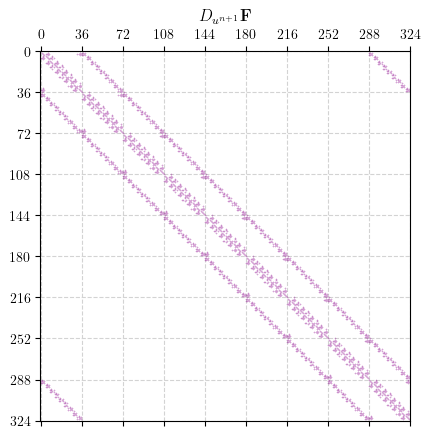

In [141]:
maxabs = max(jnp.max(J), -jnp.min(J))
fig, ax = plt.subplots()
ax.grid(color='lightgray', linestyle='dashed')
# X, Y = np.meshgrid(range((N-1)**2*4), range((N-1)**2*4))
# plt.scatter(X, Y, J.reshape((N-1)**2*4, (N-1)**2*4))
im = plt.spy(J.reshape((N-1)**2*4, (N-1)**2*4), color="darkmagenta", markersize=0.1)# vmin=0, vmax=1, cmap=cmap)
# ax2.imshow(J_manual)
plt.yticks([i for i in range(0, (N-1)**2*4+1, (N-1)*4)])
plt.xticks([i for i in range(0, (N-1)**2*4+1, (N-1)*4)])
# ax1.yaxis.grid(True, which='minor')
# ax1.xaxis.grid(True, which='minor')

plt.title(r"$D_{u^{n+1}}\mathbf{F}$")
# fig.colorbar(im)
# ax2.set_yticks([i - 0.5 for i in range(0, 36, 4)], minor='True')
# ax2.set_xticks([i - 0.5 for i in range(0, 36, 4)], minor='True')
# ax2.yaxis.grid(True, which='minor')
# ax2.xaxis.grid(True, which='minor')
# ax2.set_title("manual")
plt.savefig("ims/DF.pdf", dpi=400)

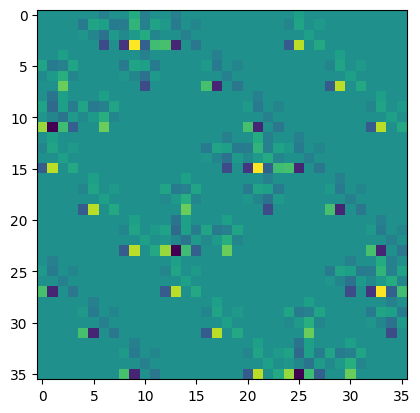

In [140]:
plt.imshow(J.reshape(36, 36) * 100 - J_manual)